#Clasificacion de imagenes del set cifar-10 con CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

##Carga de datos

In [3]:
#creamos un estandar de preprocesaimento que normaliza y ajusta los valores.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

#set de entrenamiento (descargamos directamente para mayor simplicidad)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#loader con batchs de 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)
#set de test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#loader del test
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)
#clases (sacados del dataset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 52645229.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##Arquitectura

In [5]:
import torch.nn.functional as F
#arquitectura CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #definimos los parametros basicos de la convolucion
        self.conv1 = nn.Conv2d(3, 6, 5)
        #se agrega una layer de max pooling para reducir dimensionalidad
        self.pool = nn.MaxPool2d(2, 2)
        #layer de convolucion
        self.conv2 = nn.Conv2d(6, 16, 5)
        #c
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      #basado en la documentacion de pytorch
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

In [6]:
# usamos adam y cross entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# loop
def train_model(model, data_loader, criterion, optimizer, device):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# loop Evaluacion
def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return total_loss / len(data_loader), correct_predictions.double() / len(data_loader.dataset)

# entrenamos y mandamos al dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

epochs = 10
for epoch in range(epochs):
    train_loss = train_model(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(model, testloader, criterion, device)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')

Epoch 1/10
Train loss: 1.6782, Val loss: 1.4411, Val accuracy: 0.4793
Epoch 2/10
Train loss: 1.3575, Val loss: 1.3021, Val accuracy: 0.5362
Epoch 3/10
Train loss: 1.2335, Val loss: 1.2139, Val accuracy: 0.5697
Epoch 4/10
Train loss: 1.1472, Val loss: 1.1509, Val accuracy: 0.5921
Epoch 5/10
Train loss: 1.0832, Val loss: 1.1056, Val accuracy: 0.6093
Epoch 6/10
Train loss: 1.0261, Val loss: 1.0802, Val accuracy: 0.6218
Epoch 7/10
Train loss: 0.9760, Val loss: 1.1066, Val accuracy: 0.6130
Epoch 8/10
Train loss: 0.9370, Val loss: 1.0673, Val accuracy: 0.6265
Epoch 9/10
Train loss: 0.8900, Val loss: 1.0454, Val accuracy: 0.6394
Epoch 10/10
Train loss: 0.8631, Val loss: 1.0305, Val accuracy: 0.6472


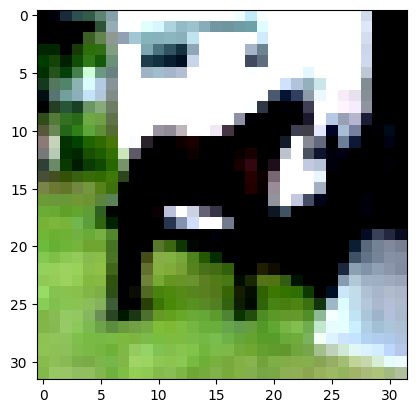

True label: horse
Predicted: horse


In [11]:

# Funcion para ver la imagen
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Indice de la imagen que quieren ver.
index = 20

# selecionamos label y imagen
image, label = testset[index]



imshow(image)
#predecimos
output = model(image.unsqueeze(0).to(device))
_, predicted = torch.max(output, 1)

# resultado predicho
print(f'True label: {classes[label]}')
print(f'Predicted: {classes[predicted[0]]}')

In [12]:
# guardar el modelo
model_save_path = 'modelcnn.pth'
torch.save(model.state_dict(), model_save_path)